<a href="https://colab.research.google.com/github/btcain44/Applied_Deep_Learning/blob/main/Generalist_Specialist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Bi-Weekly Report #3
### Brian Cain 
#### Generalist_Specialist.ipynb

In Bi-weekly report #2, I expressed some frustrations with the difficuly of effectively classifying images in the CIFAR-100 dataset. In Bi-weekly report #1, the CIFAR-10 dataset with 10 classes was pretty easy to achieve >90% accuracy on with just a simple CNN. However, in Bi-Weekly report #2 even with the use of various data-augmentation methods and the use of the Densenet architecture, I only achieved an accuracy range of 1-29% with varying results that would indicate over-fitting of the training data. My thought is that there is an obvious reason for the poor accuracy results on CIFAR-100, and that is because 100 classes is a lot for a model to effectively classify, let alone generalize to unseen data for. 

<b>Potential Solution:</b> In class we covered the paper, "Performance Inference with Ensembles of Specialists". Essentially, the idea is to combine generalist and specialist models to better classify data where a single model would be easily confused between closely related classes. I will use this strategy on the CIFAR-100 in hopes of achieving far greater accuracy here than was achieved by Densenet and Data-Augmentation methods in Bi-Weekly Report #2. 

<b>CIFAR-100 EDA:</b> Before diving more into the actual Generalist/Specialist model, I think it important to better understand the CIFAR-100 dataset and the actual classes. Below I have pasted in the "Superclass" and "Class" breakdowns from CS Toronto:

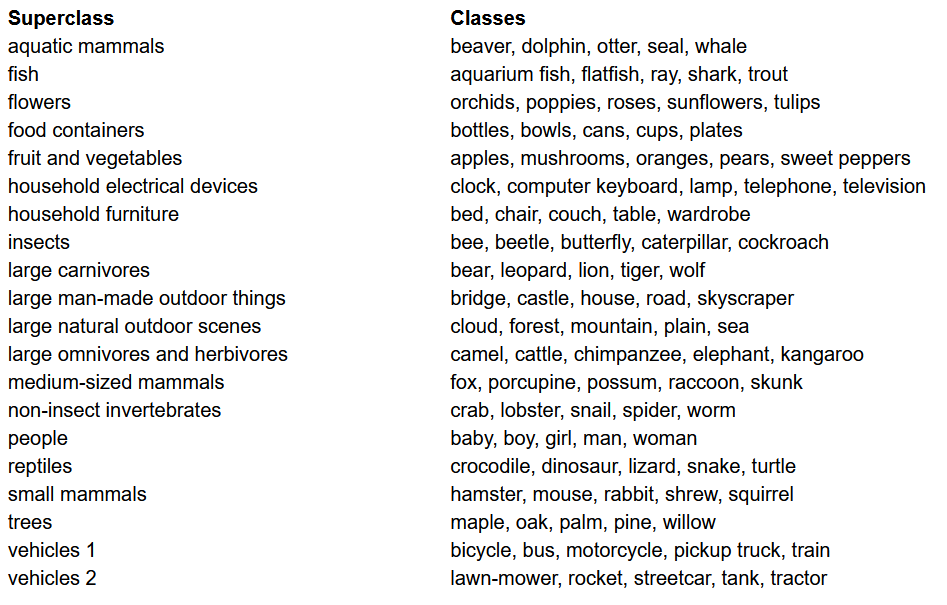

The goal will be to have a generalist classifier to identify the superclass an image belongs to with high accuracy, and then for each superclass a specialist network will classify which class within the superclass an image belongs to. 

It is important to note that by doing so, we could end up with a very large overall architecture and we'll want to keep in mind some of the small network concepts covered in class to make training more efficient. 

<b>Perform CIFAR-100 EDA:</b>

Below we must pull in data both for the 'fine' and 'coarse' labels of the dataset, where 'coarse' identify the super-classes that each image belongs to. 

In [28]:
##Import necessary packages
import numpy as np
import tensorflow as tf

##Load the CIFAR-100 dataset fine labels
from tensorflow import keras
(x_train, y_train_fine), (x_test, y_test_fine) = keras.datasets.cifar100.load_data(label_mode='fine') 
(y_train_coarse), (y_test_coarse) = keras.datasets.cifar100.load_data(label_mode='coarse')[0][1], keras.datasets.cifar100.load_data(label_mode='coarse')[1][1] 

##Format the labels in a more useable manner for eda
y_train_coarse = np.array([i[0] for i in y_train_coarse])
y_train_fine = np.array([i[0] for i in y_train_fine])

Now explore how to extract the Superclass and Class Labels:

<b>Create Model Architecture:</b>

Here is a link for future use that looks pretty useful: https://machinelearningmastery.com/model-averaging-ensemble-for-deep-learning-neural-networks/

In [29]:
##Explore what the labels look like
print('Unique Coarse Labels in the Training Dataset')
print(np.unique(y_train_coarse))
print('\n')

##Explore the fine labels of the dataset
print('Unique Fine Labels in the Training Dataset')
print(np.unique(y_train_fine))

##Print a formatting separator between the data
print('----------------------------------------------------------')

##Make sure that the shapes of the fine and coarse labels match
print('Shape of Coarse Labels Training Data')
print(y_train_coarse.shape)
print('\n')

print('Shape of Fine Labels Training Data')
print(y_train_fine.shape)

Unique Coarse Labels in the Training Dataset
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


Unique Fine Labels in the Training Dataset
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]
----------------------------------------------------------
Shape of Coarse Labels Training Data
(50000,)


Shape of Fine Labels Training Data
(50000,)


Viewing the above, we can observe that in fact there are 20 labels in y_train_coarse array representing the 20 unique super-classes of the data, and there are 100 unique classes in the y_train_fine array representing the 100 more fine-grained classes observed in the dataset.

We are also able to confirm that the data has been pulled in properly by noting the arrays for the training labels are of the correct shape of 50000 x 1, one label for each of the 50,000 training images. 

Now, let's do some EDA below and visualize images of each super-class to get the main idea of what each super-class represents. 

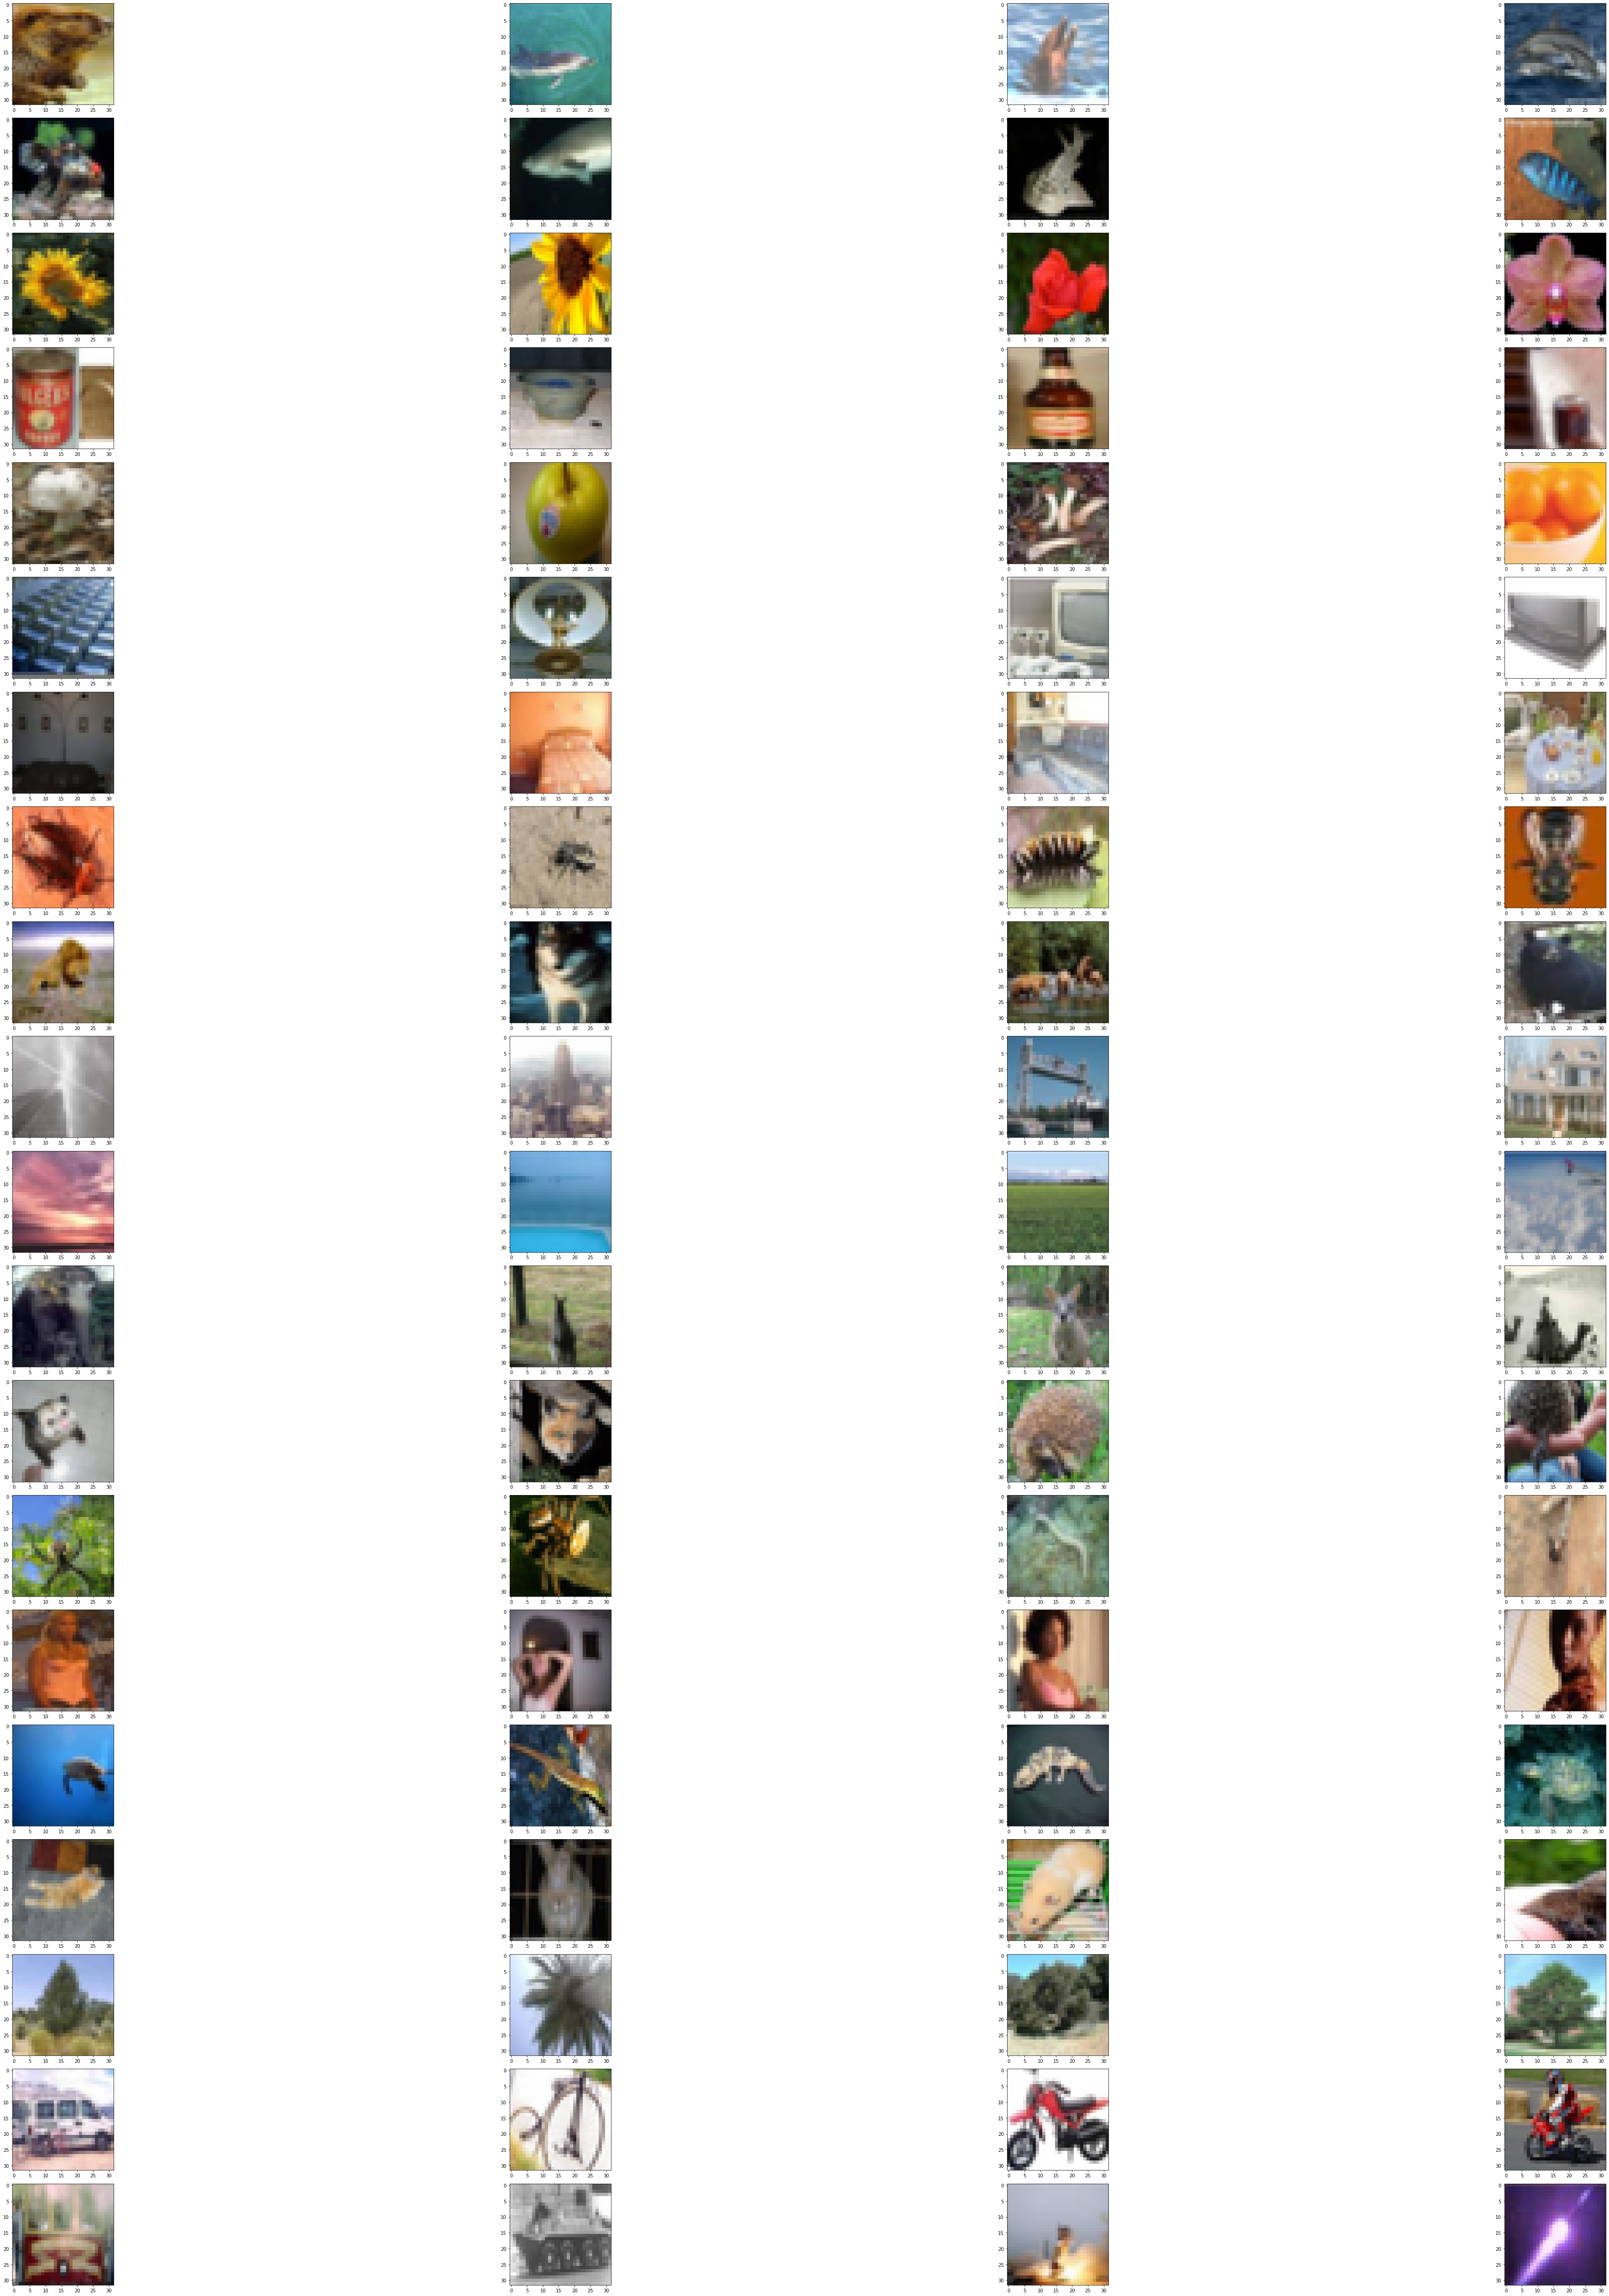

In [30]:
##Import necessary packages
import numpy as np
import matplotlib.pyplot as plt

##Define a function that will display random samples for each class for us
def display_rand_samples(labels,num_samples,imgData_x,imgData_y):
  
  ##Create figure to output images onto
  fig, ax = plt.subplots(len(labels),num_samples,figsize=(70,70))

  ##Loop through labels to display random samples for each label onto subplot
  ct = 0
  for i in labels:
    randomSamples = imgData_x[np.random.choice(np.argwhere(imgData_y==i).flatten(),num_samples)]
    for j in range(num_samples):
      ax[ct,j].imshow(randomSamples[j],cmap='gray')
    ct+=1

  fig.tight_layout()

##Call the function to plot random observations from each super-class (coarse labels)
np.random.seed(1) ##Set random seed so visualization results can be replicated
display_rand_samples(list(np.unique(y_train_coarse)),4,x_train,y_train_coarse)

The array of random observations from each image super-class above can be intimidating to look at, and it is fairly easy to see the probable cause of my shortcomings classifying this dataset last week. There is a ton of both inter-class and intra-class variation occuring here. For instance, look at the very top row which is the super class for "Aquatic Mammals", the first image appears to be a Beaver while in other images there are dolphins and other fish-like aquatic mammals. These fish-like aquatic mammals, like dolphins could easily be classified as a fish instead, which fish images can be seen in row 2. As well, the beaver could be mis-classified as part of the medium-sized mammals super-class.

So here are some observations on the difficulty of classifying this dataset using one generic CNN:
 * Large inter-class variation for coarse labels makes it difficult to correctly classify an images coarse label
  * Ex. A dolphin could be falsely classified in the fish class, a beaver could be falsely classified as a medium-sized mammal
  * Ex. A tank in the vehicles 2 super-class could be confused for objects like a train the vehicle 1 super-class
* Even if an image is given the correct coarse label, inter-class variation makes it difficult to then assign the correct fine grained label to an image
  * Ex. Large outdoor man-made things super-class, a Skyscraper and a bridge that has high pillars could be easily confused as they are visually similar

To continue to visualize the difficulty of classifying this dataset with a single model, I'll play a quick game where I use my one brain to try and guess the coarse and fine labels for random images from the aquatic mammals and fish classes, I will randomly display 5 images from each super-class of fish and aquatic animals. 

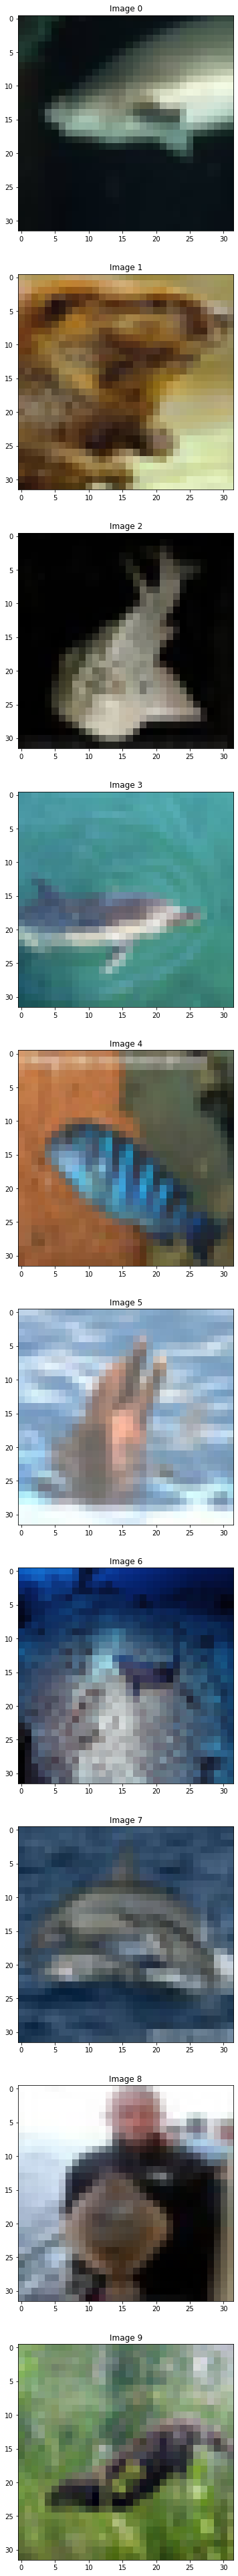

In [31]:
##Generate a chart of 10 random images, which can either be from the the aquatic mammals or fish class

##Create a subplot to plot pictures on 
fig, ax = plt.subplots(10,1,figsize=(70,70))

##Set another random seed
np.random.seed(1)

##Attain random images
random_aquaticMammals = x_train[np.random.choice(np.argwhere(y_train_coarse==0).flatten(),5)]
random_fish = x_train[np.random.choice(np.argwhere(y_train_coarse==1).flatten(),5)]

aquatic_indices = np.random.choice(np.argwhere(y_train_coarse==0).flatten(),5)
fish_indices = np.random.choice(np.argwhere(y_train_coarse==1).flatten(),5)

##Need to create a list of indexers for plotting randomly
indexers = [0,2,4,6,8]

##Assemble images into a random order
for i in range(len(random_aquaticMammals)):

  ##Create a dictonary that holds the ground truth for each image
  ground_truth = {}

  ##Generates random number to decide if the image displayed is a fish or aquatic animal
  rand_int = np.random.randint(2, size=1)

  ##Use indexer to make correct plotting decisions
  j = indexers[i]

  ##Conduct logic to inrtoduce randomness so I don't know which super-class and image comes from
  if rand_int == 2:
    ax[j].imshow(random_aquaticMammals[i])
    ax[j+1].imshow(random_fish[i])
    ground_truth['Image '+str(j)] = ['Aquatic Mammal', y_train_fine[aquatic_indices[i]]]
    ground_truth['Image '+str(j+1)] = ['Fish', y_train_fine[fish_indices[i]]]
  else:
    ax[j].imshow(random_fish[i])
    ax[j+1].imshow(random_aquaticMammals[i])
    ground_truth['Image '+str(j)] = ['Fish', y_train_fine[fish_indices[i]]]
    ground_truth['Image '+str(j+1)] = ['Aquatic Mammal', y_train_fine[aquatic_indices[i]]]
  ax[j].title.set_text('Image '+str(j))
  ax[j+1].title.set_text('Image '+str(j+1))

In [ ]:
np.random.choice(np.argwhere(y_train_coarse==0).flatten(),5)

array([ 6109, 26713, 38654,  6061, 44942])

So above, are 10 images, 5 of which are of the super-class "aquatic mammals", and 5 of which are "fish". The twist is I don't know which is which but I will attempt to predict which super-class and fine class each image belongs to. Since this classes can at time be similar, this exercise should illustrate how it is difficult for a single nueral network to predict the CIFAR-100 dataset. 

<b>My Predictions:</b>
* <b>Image 0:</b> Super = Fish, Fine = Shark
* <b>Image 1:</b> Super = Aquatic Mammal, Fine = Beaver
* <b>Image 2:</b> Super = Fish, Fine = Flatfish
* <b>Image 3:</b> Super = Aquatic Mammal, Fine = Dolphin
* <b>Image 4:</b> Super = Fish, Fine = Aquarium Fish
* <b>Image 5:</b> Super = Aquatic Mammal, Fine = Dolphin
* <b>Image 6:</b> Super = Fish, Fine = Ray
* <b>Image 7:</b> Super = Fish, Fine = Shark
* <b>Image 8:</b> Super = Aquatic Mammal, Fine = Beaver
* <b>Image 9:</b> Super = Aquatic Mammal, Fine = Otter

Now below, let's view what the actual results were

Above we can see that there are 100 unique labels in the training dataset, which makes sense as there are 100 images classes in this dataset, with 20 super-classes. 

In [32]:
##Display the results from the ground truth

##Define lists of labels and their corresponding names (used info from https://www.cs.toronto.edu/~kriz/cifar.html)
aquatic_fine = ['beaver', 'dolphin', 'otter', 'seal', 'whale']
fish_fine = ['aquarium fish', 'flatfish', 'ray', 'shark', 'trout'] 

##Display ground truth results
for i in ground_truth.keys():
  if ground_truth[i][0] == 'Fish':
    print(i+ground_truth[i][0]+fish_fine[ground_truth[i][1]-4])
  else:
    print(i+ground_truth[i][0]+aquatic_fine[ground_truth[i][1]])

IndexError: ignored

In [ ]:
ground_truth

{'Image 8': ['Fish', 67], 'Image 9': ['Aquatic Mammal', 55]}

With the results above, we can see that even with my trained eye from living on earth many years, I make some mistakes across similar super-classes and fine labels that undoubtedly a network would run into when trying to classify so many different things. As well, in this exercise I gave myself the added benefit of knowing that an image could either be from super-class "aquatic mammals", or "fish". The network has many more options to choose from. 

Notice a few things as well:
* Not only does image 8 look as if it could be "aquatic Mammals" or "fish", but it also could easily be a "people" super-class image
* Image 0, 2, 3, 5, 7 all are borderline as to whether they are dolphins or sharks and even I struggled to classify them

These observations make it apparent that perhaps a single network might not be sufficient for classification of this data. So instead, I will create and test the following Generalist/Specialist architecture based off our review of "Performing Inference with Ensembles of Specialists". 

Below I have defined an architecture where we have a single generalist model that outputs a prediction on which Super-class an image belongs to. Each super-class has its own specialist network that outputs predictions for a label within its super-class. The specialist model will only be called to make a prediction if the generalist model determines that it's super-class is most likley. 

Generalist, Specialist Architecture:

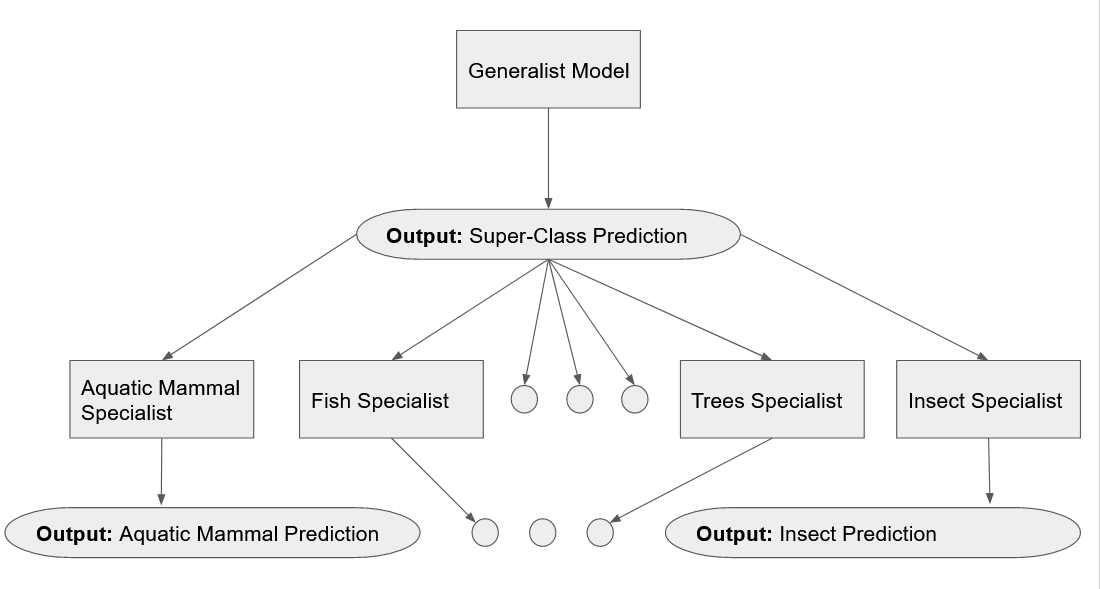

Great, now let's code it up!

### Generalist Model:

Given there are 20 super-classes, the compute requirements for this model could get out of hand quickly. Therefore, each specialist network will have the same relatively shallow architecture. To optimize performance, we also hope to have extremely high accuracy with the generalist network so we end up using the correct specialist for each image. 

In Bi-weekly report #2, we saw the power of Data Augmentation as well, so I will use data augmentation in an attempt to enhance the performance of the generalist model. Below I will re-define the RBG intensity alteration methods used in Bi-weekly report #2, as these had the best results on CIFAR-100 when tested in that report:

In [33]:
##Define function taking image dataset x data as input and returns the covariance matrix of RGB values
def cov_rgb(x_data):
    
    r, g, b = [],[],[] ##Initiate empty lists to hold R, G, and B values from across the dataset
    
    ##Compile vectors of RGB values
    for i in x_data:
        redVals, greenVals, blueVals = (np.concatenate(i[:,:,0],0), 
                                        np.concatenate(i[:,:,1],0), 
                                        np.concatenate(i[:,:,2],0))
        r.append(redVals)
        g.append(greenVals)
        b.append(blueVals)
        
    ##Combine our arrays in an appropriate format to compute the covariance
    r, g, b = (np.concatenate(r,0),
               np.concatenate(g,0),
               np.concatenate(b,0))
    cov_input = np.stack((r,g,b), axis=0)
    
    ##Compute the covariance matrix
    cov_mat = np.cov(cov_input)
    
    ##Return the covariance matrix
    return cov_mat

##Define function that performs channel intensity ata augmentation on an input image
##Takes in the covariance matrix for RGB channels in the dataset and the input image itself
def change_channel_intensity(input_image, rgb_cov_mat, guassian_noise_mu, guassian_noise_sigma):
    
    ##Compute the eigenvalues and eigenvector of the RGB covariance matrix
    eigValues, eigVector = np.linalg.eig(rgb_cov_mat)
    
    ##Loop through pixels in the image and adjust pixels intensities as defined by method above
    i_ct = 0 
    for i in input_image:
        j_ct = 0
        for j in i:
            
            ##Compute the pixel intensity calculation
            noise = np.random.normal(guassian_noise_mu, guassian_noise_sigma, 3) ##Generate random gaussian noise
            addition_component = np.multiply(noise, eigValues) ##Need better naming convention for this variable
            multiplication_component = np.matmul(eigVector,np.transpose(addition_component))
            input_image[i_ct][j_ct] = j+multiplication_component
        
        ##Update the count iterators
            j_ct+=1
        i_ct+=1
            
    ##Return the image with alterated pixel values
    return input_image

In [34]:
##Alter a random 20% of the training data according to the RGB intensity method above
np.random.seed(0)
rand_images = np.random.randint(0, 50000, size=int(50000*.2), dtype=int)

##Compute the covariance matrix of the dataset
x_train_intensity = []
y_train_intensity = []
cov_mat = cov_rgb(x_train)
for i in rand_images:
    intensityImg = change_channel_intensity(np.copy(x_train[i]), cov_mat, 0, .001)
    x_train_intensity.append(intensityImg)
    y_train_intensity.append(y_train_coarse[i])
x_train_intensity = np.concatenate((x_train, x_train_intensity), axis=0)
y_train_intensity = np.concatenate((y_train_coarse, y_train_intensity),axis=None)

Bi-weekly report #2 also mentioned trying to ensemble data augmentation methods, so I will do that here by as well applying mix-up to the training data. 

In [35]:
##Define a function that performs mixup two images 
def mixup(image1, image2, label1, label2, beta_params):
    
    ##Generate sample from lambda distribution 
    lambda_val = np.random.beta(beta_params[0], beta_params[1])
    
    ##Perform mix-up operation 
    newImg = lambda_val*image1 + (1-lambda_val)*image2
    newLabel = lambda_val*label1 + (1-lambda_val)*label2

    ##Assign new label to the label it is closest to
    if np.abs((newLabel-label1)) >= np.abs((newLabel-label2)):
      newLabel = label2
    else:
      newLabel = label1
    
    return newImg.astype(int), newLabel

In [36]:
##Define new random images
np.random.seed(1) ##Set a different random seed that when we did RGB pixel alteration
rand_images = np.random.randint(0, 50000, size=int(50000*.2), dtype=int)

##Create training dataset using mixup
x_train_mixup = []
y_train_mixup = []
for i in rand_images:
    mixup_result = (mixup(x_train_intensity[i],x_train_intensity[i-1],y_train_intensity[i],y_train_intensity[i-1],[.2,.2]))
    x_train_mixup.append(mixup_result[0])
    y_train_mixup.append(mixup_result[1])

##Translate training data into numpy arrays
x_train_mixup = np.array(x_train_mixup)
y_train_mixup = np.array(y_train_mixup)

##Concatenate new data onto existing training data
x_train_mixup = np.concatenate((x_train_intensity, x_train_mixup), axis=0)
y_train_mixup = np.concatenate((y_train_intensity, y_train_mixup),axis=None)

Now Define the Generalist Network:

In [37]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, GlobalAveragePooling2D, Dropout

##Create class for a model (considered more "expert" on tensorflow site)
class GeneralistModel(Model):
    
    def __init__(self):
        
        super(GeneralistModel, self).__init__()
        self.conv1 = Conv2D(32,(1,1),activation='relu')
        self.batch1 = BatchNormalization()
        
        self.conv2 = Conv2D(64,(3,3),activation='relu')
        self.batch2 = BatchNormalization()
        
        self.conv3 = Conv2D(128,(3,3),activation='relu')
        self.batch3 = BatchNormalization()

        self.conv4 = Conv2D(256,(3,3),activation='relu')
        self.batch4 = BatchNormalization()
        
        self.globAvgPool = GlobalAveragePooling2D() ##Aids in regularization
        
        self.d1 = Dense(128, activation='relu')
        self.drop = Dropout(.5)
        self.d2 = Dense(20, activation='softmax')
        
    def call(self, x):
        x = self.conv1(x)
        x = self.batch1(x)
        x = self.conv2(x)
        x = self.batch2(x)
        x = self.conv3(x)
        x = self.batch3(x)
        x = self.conv4(x)
        x = self.batch4(x)
        x = self.globAvgPool(x)
        x = self.d1(x)
        x = self.drop(x)
        return self.d2(x)

##Create an instance of the model
generalist = GeneralistModel()

Below let's display the details of this Generalist model:

We can see above that purposefully, this is a relatively shallow model with layers that have been quantized. Recall this is since we will have so many networks from the generalist model to all the specialists that we don't want super deep networks as this is expensive, and ideally quantization will aid in this as well.

Go ahead and normalize the data and split the data into train/validation for the generalist network:

In [38]:
##Conduct a step of data normalization
x_train_mixup, x_test = x_train_mixup / 255.0, x_test / 255.0

##Perform train/validation split on the data
from sklearn.model_selection import train_test_split
x_train_generalist, x_val, y_train_generalist, y_val = train_test_split(x_train_mixup, y_train_mixup, test_size=0.25, random_state=42)

Now train the Generalist model to predict Super-classes:

In [39]:
##Compile the model
generalist.compile(optimizer='adam',
                             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                             metrics=['accuracy'])

##Fit the model
generalist_fit = generalist.fit(x_train_generalist, y_train_generalist, 
                                          batch_size=32, epochs=25, validation_data=(x_val, y_val),verbose=2)

Epoch 1/25
1641/1641 - 83s - loss: 2.5486 - accuracy: 0.2161 - val_loss: 2.2714 - val_accuracy: 0.2894
Epoch 2/25
1641/1641 - 51s - loss: 2.2185 - accuracy: 0.3141 - val_loss: 2.0148 - val_accuracy: 0.3636
Epoch 3/25
1641/1641 - 50s - loss: 2.0273 - accuracy: 0.3662 - val_loss: 1.9407 - val_accuracy: 0.3959
Epoch 4/25
1641/1641 - 50s - loss: 1.8792 - accuracy: 0.4123 - val_loss: 1.7349 - val_accuracy: 0.4517
Epoch 5/25
1641/1641 - 50s - loss: 1.7503 - accuracy: 0.4537 - val_loss: 1.6137 - val_accuracy: 0.4859
Epoch 6/25
1641/1641 - 50s - loss: 1.6441 - accuracy: 0.4862 - val_loss: 1.5522 - val_accuracy: 0.5106
Epoch 7/25
1641/1641 - 50s - loss: 1.5562 - accuracy: 0.5108 - val_loss: 1.4750 - val_accuracy: 0.5254
Epoch 8/25
1641/1641 - 50s - loss: 1.4821 - accuracy: 0.5318 - val_loss: 1.4114 - val_accuracy: 0.5465
Epoch 9/25
1641/1641 - 50s - loss: 1.4102 - accuracy: 0.5550 - val_loss: 1.4446 - val_accuracy: 0.5442
Epoch 10/25
1641/1641 - 50s - loss: 1.3461 - accuracy: 0.5711 - val_loss:

Before doing anything else, I will save the model so nothing is lost, since it took so long to train:

In [40]:
generalist.save('generalist')

INFO:tensorflow:Assets written to: generalist/assets


Now lets view how this generalist model does on the testing data:

In [41]:
##First we need to correctly format the y-label coarse and fine testing data
y_test_coarse = np.array([i[0] for i in y_test_coarse])
y_test_fine = np.array([i[0] for i in y_test_fine]) ##This will help us later on when doing the specialist models

In [42]:
##Evaluate the testing accuracy of the model
print('Test Accuracy of Generalist Model:')
generalist.evaluate(x_test,  y_test_coarse, verbose=0)[1]

Test Accuracy of Generalist Model:


0.5794000029563904

Well, I would have liked to of achieved better accuracy for the generalist model since it is the first step on the prediction process of the Generalist/Specialist framework. It is easy to see that the model over-fit the data during training with a training accuracy of 73.09% in the last epoch, and a test accuracy above of 57.94%. In the notebook, <b>Small_Net_Generalist.ipynb</b>, I've explored improving this generalist model with more ideas covered in the small networks module of the course. I did so because the generalist is a very important component of this architecture.

### Specialist Models:

Below I define 20 specialist models with the same architectures, all of which will use quantization as well to reduce compute necessary for model training/deployment. 

Another note is that in my Bi-Weekly Report #2 feedback it was mentioned that creating models as class objects rather than re-intializing a sequential model is more efficient when creating many models with the same architecture, so I will do that here. 

Before creating any architecture however, we must split up all the training and test data by super-class, so that each specialist model only predicts labels for it's assigned super-class. 

In [65]:
##Define a function that returns training and test data for each individual super-class
def super_class_split(x_data, y_data_coarse, y_data_fine):

  ##Create a dictionary that will hold all the split data for training and testing
  specialist_data = {}

  ##Go through each super-class and get its respective training data/labels
  for i in np.unique(y_data_coarse):

    ##Get the y data fine labels for the fine labels for the super_class
    y = y_data_fine[np.argwhere(y_data_coarse==i).flatten()]

    ##Get the corresponding x data
    x = x_data[np.argwhere(y_data_coarse==i).flatten()]

    ##Add the data to corresponding dictionary location 
    specialist_data[i] = (x,y)

  ##Return the split data
  return specialist_data

##Call function to split training data into super-class partitions
specialist_data = super_class_split(x_train, y_train_coarse, y_train_fine)

Now lets explore some details about the datasets for each Super-class. Specifically we are interesting in the following:
* Amount of training data available for each super-class
* Number of fine classes per super-class

Specifically we need to know the number of fine labels per super-class because we will need to incorporate this into our softmax.

In [44]:
##Determine the Amount of training data available for each super-class
print('Training Data Available for each Super-class')
print('--------------------------------------------')
for i in specialist_data.keys():
  print('Training Samples for Super-class '+str(i)+': '+str(len(specialist_data[i][0])))
print('\n')

##Now display the number of unique fine labels in each super-class
print('Unique Fine Labels in Each Super-class')
print('-------------------------------------------')
for i in specialist_data.keys():
  print('Unique Fine Labels in Super-class '+str(i)+': '+str(len(np.unique(specialist_data[i][1]))))

Training Data Available for each Super-class
--------------------------------------------
Training Samples for Super-class 0: 2500
Training Samples for Super-class 1: 2500
Training Samples for Super-class 2: 2500
Training Samples for Super-class 3: 2500
Training Samples for Super-class 4: 2500
Training Samples for Super-class 5: 2500
Training Samples for Super-class 6: 2500
Training Samples for Super-class 7: 2500
Training Samples for Super-class 8: 2500
Training Samples for Super-class 9: 2500
Training Samples for Super-class 10: 2500
Training Samples for Super-class 11: 2500
Training Samples for Super-class 12: 2500
Training Samples for Super-class 13: 2500
Training Samples for Super-class 14: 2500
Training Samples for Super-class 15: 2500
Training Samples for Super-class 16: 2500
Training Samples for Super-class 17: 2500
Training Samples for Super-class 18: 2500
Training Samples for Super-class 19: 2500


Unique Fine Labels in Each Super-class
---------------------------------------

Great! So observing the class above we get some really convienent results. Each super-class has the same number of training samples, which is great because it won't put certain specialist models at disadvantages if they were to have a lesser amount of training data, and thus likely being a less robust specialist as compared to others. 

Another great observation is that each super-class is composed of 5 finer labeled classes, meaning I can uniformly create the specialist architecture without worrying about adjusting the softmax layer at the end. 

Define shallow architecture specialist models using class definitions: 

In [45]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, GlobalAveragePooling2D, Dropout

##Create class for a model (considered more "expert" on tensorflow site)
class SpecialistModel(Model):
    
    def __init__(self):
        
        super(SpecialistModel, self).__init__()
        self.conv1 = Conv2D(32,(1,1),activation='relu')
        self.batch1 = BatchNormalization()
        
        self.conv2 = Conv2D(64,(3,3),activation='relu')
        self.batch2 = BatchNormalization()
        
        self.conv3 = Conv2D(128,(3,3),activation='relu')
        self.batch3 = BatchNormalization()
        
        self.globAvgPool = GlobalAveragePooling2D() ##Aids in regularization
        
        self.d1 = Dense(128, activation='relu')
        self.d2 = Dense(5, activation='softmax')
        
    def call(self, x):
        x = self.conv1(x)
        x = self.batch1(x)
        x = self.conv2(x)
        x = self.batch2(x)
        x = self.conv3(x)
        x = self.batch3(x)
        x = self.globAvgPool(x)
        x = self.d1(x)
        return self.d2(x)

Now that the architecture has been defined let's compile the models. 

In [55]:
##Create a storage list for the models
specialists = []

##Loop through to create instances of each model
for i in range(20):
  specialist = SpecialistModel()
  specialist.compile(optimizer='adam',
                     loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                     metrics=['accuracy'])
  specialists.append(specialist)

We should also acknowledge that 2500 training samples is not a lot for each specialist model to work on. Therefore, each specialist would likely benefit from having data augmentation performed on the data. Therefore, for each training set I will introduce RGB Intensity Alteration data augmentation.

In [47]:
##Alter a random 40% of the training data according to the RGB intensity method above
np.random.seed(1)
rand_images = np.random.randint(0, 2500, size=int(2500*.4), dtype=int)

##Loop through all super-classes
for i in range(20):

  ##Create training dataset using mixup
  x_train_mixup = []
  y_train_mixup = []
  for j in rand_images:
      mixup_result = (mixup(specialist_data[i][0][j],specialist_data[i][0][j-1],
                            specialist_data[i][1][j],specialist_data[i][1][j-1],[.2,.2]))
      x_train_mixup.append(mixup_result[0])
      y_train_mixup.append(mixup_result[1])

  ##Translate training data into numpy arrays
  x_train_mixup = np.array(x_train_mixup)
  y_train_mixup = np.array(y_train_mixup)

  ##Concatenate new data onto existing training data
  specialist_data[i] = (np.concatenate((np.array(specialist_data[i][0]), x_train_mixup), axis=0),
                        np.concatenate((np.array(specialist_data[i][1]), y_train_mixup),axis=None))

Now, each specialist model needs their training data split into a training and validation set:

In [48]:
##Create storage locations for the data
specialist_train = {}
specialist_val = {}

##Loop through the separated super-class data to make a training and validiation set for each super-class
for i in range(20):

  ##Perform train/validation split on the data
  from sklearn.model_selection import train_test_split
  x_t, x_v, y_t, y_v = train_test_split((specialist_data[i][0])/255, specialist_data[i][1], test_size=0.25,random_state=42)
  specialist_train[i] = [x_t,y_t]
  specialist_val[i] = [x_v,y_v] 

There is one more data formatting issue we must resolve before moving on. Since the y labels were split up by super-class, they are not ordered from 0-n now, where n is the largest number. We must fix this to have a valid model that works. 

In [49]:
##Define function that encodes labels to be 0,1,2,3,4. 
def label_encoder(label_data):

  ##Sort the labels from smallest to largest uniquely
  sorted_labels = list(np.sort(np.unique((label_data))))

  ##Replace each label with its sorted integer
  new_label_data = [sorted_labels.index(i) for i in label_data]

  ##Return the new label data
  return np.array(new_label_data)

##Now fix all the labels in the training and validation sets
for i in specialist_train.keys():

  ##Encode the categorical labels
  specialist_train[i][1] = label_encoder(specialist_train[i][1])
  specialist_val[i][1] = label_encoder(specialist_val[i][1])

Now fit the specialist models:

In [57]:
##Fit the models
specialist_fits = []
for i in range(20):
  specialist_fit = specialists[i].fit(specialist_train[i][0],specialist_train[i][1],
                                      batch_size=24, epochs=25, 
                                      validation_data=(specialist_val[i][0], specialist_val[i][1]),
                                      verbose=0)
  print('Specialist '+str(i)+' has completed training')
  print('\n')

Specialist 0 has completed training


Specialist 1 has completed training


Specialist 2 has completed training


Specialist 3 has completed training


Specialist 4 has completed training


Specialist 5 has completed training


Specialist 6 has completed training


Specialist 7 has completed training


Specialist 8 has completed training


Specialist 9 has completed training


Specialist 10 has completed training


Specialist 11 has completed training


Specialist 12 has completed training


Specialist 13 has completed training


Specialist 14 has completed training


Specialist 15 has completed training


Specialist 16 has completed training


Specialist 17 has completed training


Specialist 18 has completed training


Specialist 19 has completed training




Now each specialist model has been trained, below I will display that each specialist model achieved on their assigned super-class. 

As a part of doing so, I will also need to first split the test data into the respective super-classes for classification and encode the labels like was done above. 

In [66]:
##Call previously defined function to obtain test data
specialist_test = super_class_split(x_test, y_test_coarse, y_test_fine)

In [70]:
##Perform label encoding on the fine label 
for i in specialist_test.keys():

  ##Encode the categorical labels
  specialist_test[i] = (specialist_test[i][0],label_encoder(specialist_test[i][1]))

In [74]:
##Display the accuracy for each specialist model
ct = 0
for i in specialists:
  print('Test Accuracy for Specialist '+str(ct))
  acc = i.evaluate(specialist_test[ct][0],specialist_test[ct][1], verbose=0)[1]
  print(acc)
  print('-------------------------------')
  ct+=1

Test Accuracy for Specialist 0
0.5339999794960022
-------------------------------
Test Accuracy for Specialist 1
0.6700000166893005
-------------------------------
Test Accuracy for Specialist 2
0.6439999938011169
-------------------------------
Test Accuracy for Specialist 3
0.6200000047683716
-------------------------------
Test Accuracy for Specialist 4
0.7239999771118164
-------------------------------
Test Accuracy for Specialist 5
0.6140000224113464
-------------------------------
Test Accuracy for Specialist 6
0.578000009059906
-------------------------------
Test Accuracy for Specialist 7
0.6779999732971191
-------------------------------
Test Accuracy for Specialist 8
0.7080000042915344
-------------------------------
Test Accuracy for Specialist 9
0.6980000138282776
-------------------------------
Test Accuracy for Specialist 10
0.7799999713897705
-------------------------------
Test Accuracy for Specialist 11
0.656000018119812
-------------------------------
Test Accuracy fo

Above the results can be seen for the test accuracy on each super-class. Some of these results like for Speicalist 19, 8 and 4 are encouraging while others like 16, 15, 14 and 0 are certainly a cause for concern. 

### <u>Bring it Back Together:</u> Generalist + Specialist

Now that I've trained the Generalist and the Specialist models, it is time to test them all out working together as an ensemble. 

Generate Predictions on Test data using the Generalist Model for the Super-Class:

In [82]:
##Generate predictions of the super-class for each observation
supClass_preds = generalist.predict(x_test)

##Create a list of formatted predictions
formatted_sup_preds = []
for i in supClass_preds:
  formatted_sup_preds.append(np.argmax(i))

The code above uses the Generalist model we created to generate predictions for what super class an image belongs to. Next in the code below, we will use this super-class prediction to direct each testing data point to a more specific specialist model in order to predict it's finer class. 

In [108]:
##Create a storage location holding binary values indicating if a test point was predicted correct by the overall ensemble model
prediction_bin = []

##Loop through each data points generalist model prediction
ct = 0
for i in formatted_sup_preds:

  ##Use prediction to determine which specialist model we'll use to predict the finer label
  specialist_predictor = specialists[i]

  ##Have specialist make a prediction for the data point
  prediction = np.argmax(specialist_predictor.predict(x_test[[ct]]))

  ##Determine which label encoding the prediction belongs to for that specialist
  sorted_labels = list(np.sort(np.unique((y_test_fine[np.argwhere(y_test_coarse==i).flatten()]))))
  prediction = sorted_labels[prediction]

  ##Determine if the prediction is correct
  if prediction == y_test_fine[ct]:
    prediction_bin.append(1)
  else:
    prediction_bin.append(0)

  ##Update iterator for next point
  ct+=1

In [109]:
prediction_bin = np.array(prediction_bin)
print('Accuracy of Generalist/Specialist model on CIFAR-100:')
len(prediction_bin[prediction_bin==1])/10000

Accuracy of Generalist/Specialist model on CIFAR-100:


0.3962

So we have that the final test accuracy of trying out this Generalist Specialist ensemble method from the Small Networks module had a test accuracy of 39.62%. Below see my final interpretation. 

## Final Interpretation:

Well, 39.62% accuracy still isn't great but it is progress from Bi-Weekly Report #2's best CIFAR-100 accuracy which was around 29%. I think that the real bottleneck for accuracy here is the generalist model only having an accuracy of 57.94%. If the accuracy of the generalist model were to increase than it would pave the way for much higher overall accuracy because the data would then be sent to the correct specialist model more frequently. As another part of my Bi-weekly report, I aim to make the generalist model better in <b>Small_Net_Generalist.ipynb</b>. Although the generalist network is not the only issue. Several of the specialist networks had accuracy of < 50% when predicting the classes within its assigned super-class, which isn't good when relying on the generalist/specialist framework. 

Overall I actually had a ton of fun with this exercise. It was pretty strenous in terms of figuring out how to adjust the code to train the generalist model on coarse labels and each specialist on its own fine labels, but the improved accuracy from Bi-weekly report #2 made the process rewarding. 